In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from nurisc import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from nurisc.matching import matching, matching_dataset
from nurisc.models import Config2D, nurisc2D, nuriscData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

C:\Users\es255022\AppData\Local\Temp\ipykernel_10108\3250185321.py:5: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
Model: "denseUnet_fNLA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 528, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv00_block1_conv (Conv2D)    (None, 528, 240, 5)  45          ['input_1[0][0]']                
                                                                                                  
 conv00_block1_bn (BatchNormali  (None, 528, 240, 5)  35         ['conv00_block1_conv[0][0]']     
 zation)                                                                          

nadam.py (78): The `lr` argument is deprecated, use `learning_rate` instead.


                                                                                                  
 conv20_block9_2_bn (BatchNorma  (None, 132, 60, 5)  35          ['conv20_block9_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv20_block9_2_actv (Activati  (None, 132, 60, 5)  0           ['conv20_block9_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv20_block9_drop (Dropout)   (None, 132, 60, 5)   0           ['conv20_block9_2_actv[0][0]']   
                                                                                                  
 conv20_block9_concat (Concaten  (None, 132, 60, 65)  0          ['conv20_block8_concat[0][0]',   
 ate)     

In [2]:
#CoNSeP
from cv2 import imread
X= sorted(glob('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/cpm15-20220821T135408Z-001/cpm15/Images/*.png'))
print(len(X))
X = list(map(imread,X))
from scipy.io import  loadmat
Y1= sorted(glob('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/cpm15-20220821T135408Z-001/cpm15/Labels/*.mat'))
print(len(Y1))
# np.int(Y1)
Y1=list(map(loadmat,Y1))

# Y = [y[...,0] for y in Y]
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

15
15


In [3]:
Y=[]
Z=[]
for i in range(len(Y1)):
 for k, v in Y1[i].items():
    if k=='inst_map':
      
        Y.append(v)
        print(v)
    if k=='cls_map':
       Z.append(v)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 5 5 ... 0 0 0]
 [5 5 5 ... 0 0 0]
 [5 5 5 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[  0   0   0 ...   0   0   0]
 [  0   0 131 ...   0   0   0]
 [  0   0 131 ...   0   0   0]
 ...
 [143 143 143 ... 167 167   0]
 [  0 143 143 ... 167 167   0]
 [  0 143 143 ... 167 167   0]]
[[218 218 218 ...   0   0   0]
 [218 218 218 ...   0   0   0]
 [218 218 218 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
[[  0   0   0 ..

In [4]:
Y=np.asarray(Y)

1733489089.py (1): Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [5]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

Normalizing image channels independently.


100%|██████████| 15/15 [00:00<00:00, 68.85it/s]


In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.3 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  15
- training:        11
- validation:       4


In [8]:
from nurisc.plot import render_label
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):


    fig, (ai,al) = plt.subplots(1,2, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title)
    al.imshow(render_label(lbl, .7*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap= ListedColormap(["lime"])))
    al.set_title(lbl_title)
    
    plt.tight_layout()
    for a in ai,al:
        a.axis("off")
    return ai,al

In [10]:
print(Config2D.__doc__)

Configuration for a :class:`nurisc2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the nuclei.
    n_channel_in : int
        Number of channels of given input image (default: 1).

    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class prediction (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    

In [11]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 64

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = True,
    n_channel_in = n_channel,
    backbone='ffnet',
  

)
print(conf)
vars(conf)

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=65, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=64, grid=(2, 2), backbone='ffnet', n_classes=None, unet_n_depth=4, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=True, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, head_blocks=2, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_class_loss='cce_tversky', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 65,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 64,
 'grid': (2, 2),
 'backbone': 'ffnet',
 'n_classes': None,
 'unet_n_depth': 4,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': True,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'head_blocks': 2,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_class_loss': 'cce_tversky',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_

In [16]:
# model = nurisc2D(config=None, name='final_cpm15', basedir='C:/Users/es255022/OneDrive - Teradata/Desktop/')

model = nurisc2D(config=None, name='cpm-15', basedir='C:/Users/es255022/OneDrive - Teradata/Desktop/')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.561832, nms_thresh=0.3.


In [13]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
print('done')
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

structured_function.py (264): Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.


1/1 [==============================] - 0s 305ms/step
median object size:      [26. 21.]
network field of view :  [128 128]
done


In [16]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img
# def random_crop(img,mask):
#     assert img.ndim >= mask.ndim
#     axes = tuple(range(mask.ndim))
#     perm = tuple(np.random.permutation(axes))
#     img= iaa.Crop(percent=(0, 0.3)) # crop image
#     mask= iaa.Crop(percent=(0, 0.3))
#     return img, mask 
# def random_img_shearing(img,mask):
#   shear = iaa.Affine(shear=(0,40))
#   img = shear.augment_image(img)
#   mask = shear.augment_image(mask)
#   return img, mask
def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    # x,y =random_crop(x,y)
    # x,y =random_img_shearing(x,y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

In [15]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=1, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    # model = nurisc2D.from_pretrained('2D_cryonuseg')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,epochs=200, steps_per_epoch=64)
    print('done')
None;

1.0 0.7
class_loss:    cce_tversky
class_weights: [1, 1]
focal_gamma:   0
Epoch 1/200



KeyboardInterrupt



In [22]:
quick_demo = False
if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:04<00:01,  3.42it/s, 0.547 -> 0.666]


Using optimized values: prob_thresh=0.561832, nms_thresh=0.3.
Saving to 'thresholds.json'.


In [17]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

  0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 163ms/step


 25%|██▌       | 1/4 [00:01<00:03,  1.09s/it]

1/1 [==============================] - 0s 142ms/step


 50%|█████     | 2/4 [00:01<00:01,  1.09it/s]

1/1 [==============================] - 0s 160ms/step


 75%|███████▌  | 3/4 [00:02<00:00,  1.42it/s]

1/1 [==============================] - 0s 166ms/step


100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


In [ ]:
plot_img_label(X_val[0], Y_val[0], lbl_title="GroundTruth")
plot_img_label(X_val[0], Y_val_pred[0], lbl_title="Proposed_Predicted")

In [ ]:
plot_img_label(X_val[0],Y_val[0], lbl_title="GroundTruth")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="Proposed_Predicted")

In [ ]:
plot_img_label(X_val[1],Y_val[1], lbl_title="GroundTruth")
plot_img_label(X_val[1],Y_val_pred[1], lbl_title="Proposed_Predicted")

In [ ]:
plot_img_label(X_val[2],Y_val[2], lbl_title="GroundTruth")
plot_img_label(X_val[2],Y_val_pred[2], lbl_title="Proposed_Predicted")

In [ ]:
plot_img_label(X_val[3],Y_val[3], lbl_title="GroundTruth")
plot_img_label(X_val[3],Y_val_pred[3], lbl_title="Proposed_Predicted")

In [ ]:
plot_img_label(X_val[1],Y_val[1], lbl_title="GroundTruth")
plot_img_label(X_val[1],Y_val_pred[1], lbl_title="Proposed_Predicted")

In [ ]:

plot_img_label(X_val[2], Y_val[2], lbl_title="GroundTruth")
plot_img_label(X_val[2], Y_val_pred[2], lbl_title="Proposed_Predicted")

In [ ]:
plot_img_label(X_val[3], Y_val[3], lbl_title="GroundTruth")
plot_img_label(X_val[3], Y_val_pred[3], lbl_title="Proposed_Predicted")

In [36]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:00<00:00, 23.26it/s]


In [37]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=57, tp=483, fn=114, precision=0.8944444444444445, recall=0.8090452261306532, accuracy=0.7385321100917431, f1=0.8496042216358839, n_true=597, n_pred=540, mean_true_score=0.6274898854931396, mean_matched_score=0.7755930882803401, panoptic_quality=0.6589471620745898, segmentation_quality=0.7755930882803401, detection_quality=0.8496042216358839, by_image=False)

1219126287.py (5): marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
1219126287.py (20): marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.


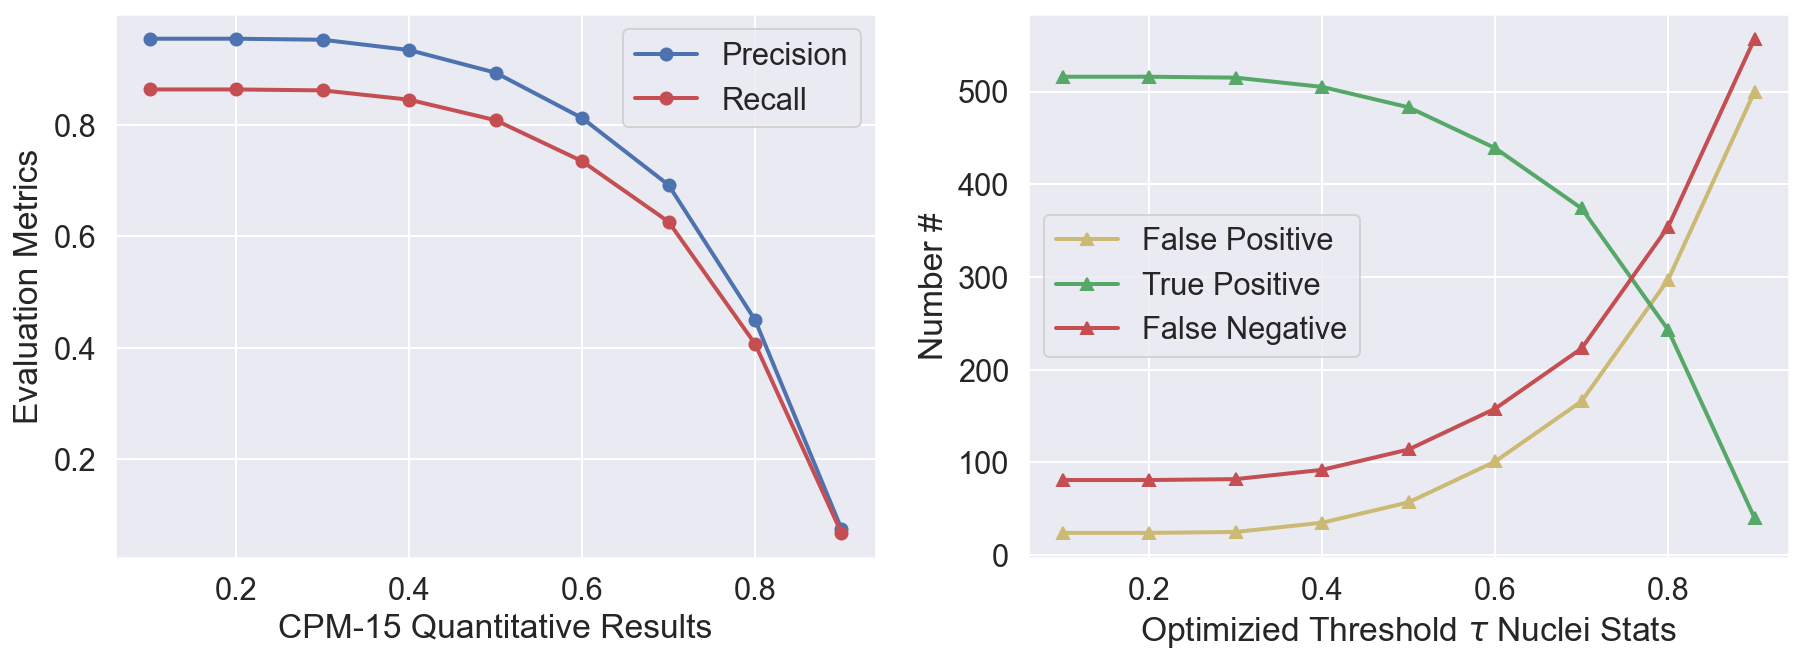

In [100]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
colors = "brcymkw"
i= 0
for m in ('precision', 'recall'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m,c=colors[i],marker='o')
    i=i+1
ax1.set_xlabel(r'CPM-15 Quantitative Results')
ax1.set_ylabel('Evaluation Metrics')
# t="CPM-17 Quantitative Results"
# ax1.title(t)
# ax1.grid()
ax1.legend()
L=ax1.legend()
L.get_texts()[0].set_text('Precision')
L.get_texts()[1].set_text('Recall')

colors1 = "ygrmgrcy"
j=0
for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m,c=colors1[j],marker='^')
    j=j+1
ax2.set_xlabel(r'Optimizied Threshold $\tau$ Nuclei Stats')
ax2.set_ylabel('Number #')
# ax2.grid()
ax2.legend();
L1=ax2.legend()
L1.get_texts()[0].set_text('False Positive')
L1.get_texts()[1].set_text('True Positive')
L1.get_texts()[2].set_text('False Negative')

In [55]:
stats1=stats[taus.index(0.5)]

In [56]:
stats1

DatasetMatching(criterion='iou', thresh=0.5, fp=57, tp=483, fn=114, precision=0.8944444444444445, recall=0.8090452261306532, accuracy=0.7385321100917431, f1=0.8496042216358839, n_true=597, n_pred=540, mean_true_score=0.6274898854931396, mean_matched_score=0.7755930882803401, panoptic_quality=0.6589471620745898, segmentation_quality=0.7755930882803401, detection_quality=0.8496042216358839, by_image=False)

In [59]:
type(stats1)

nurisc.matching.DatasetMatching

In [84]:

taus1 = [ 0.3,0.4, 0.5, 0.6, 0.7, 0.8]
stats1 = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus1)]

100%|██████████| 6/6 [00:00<00:00, 21.30it/s]


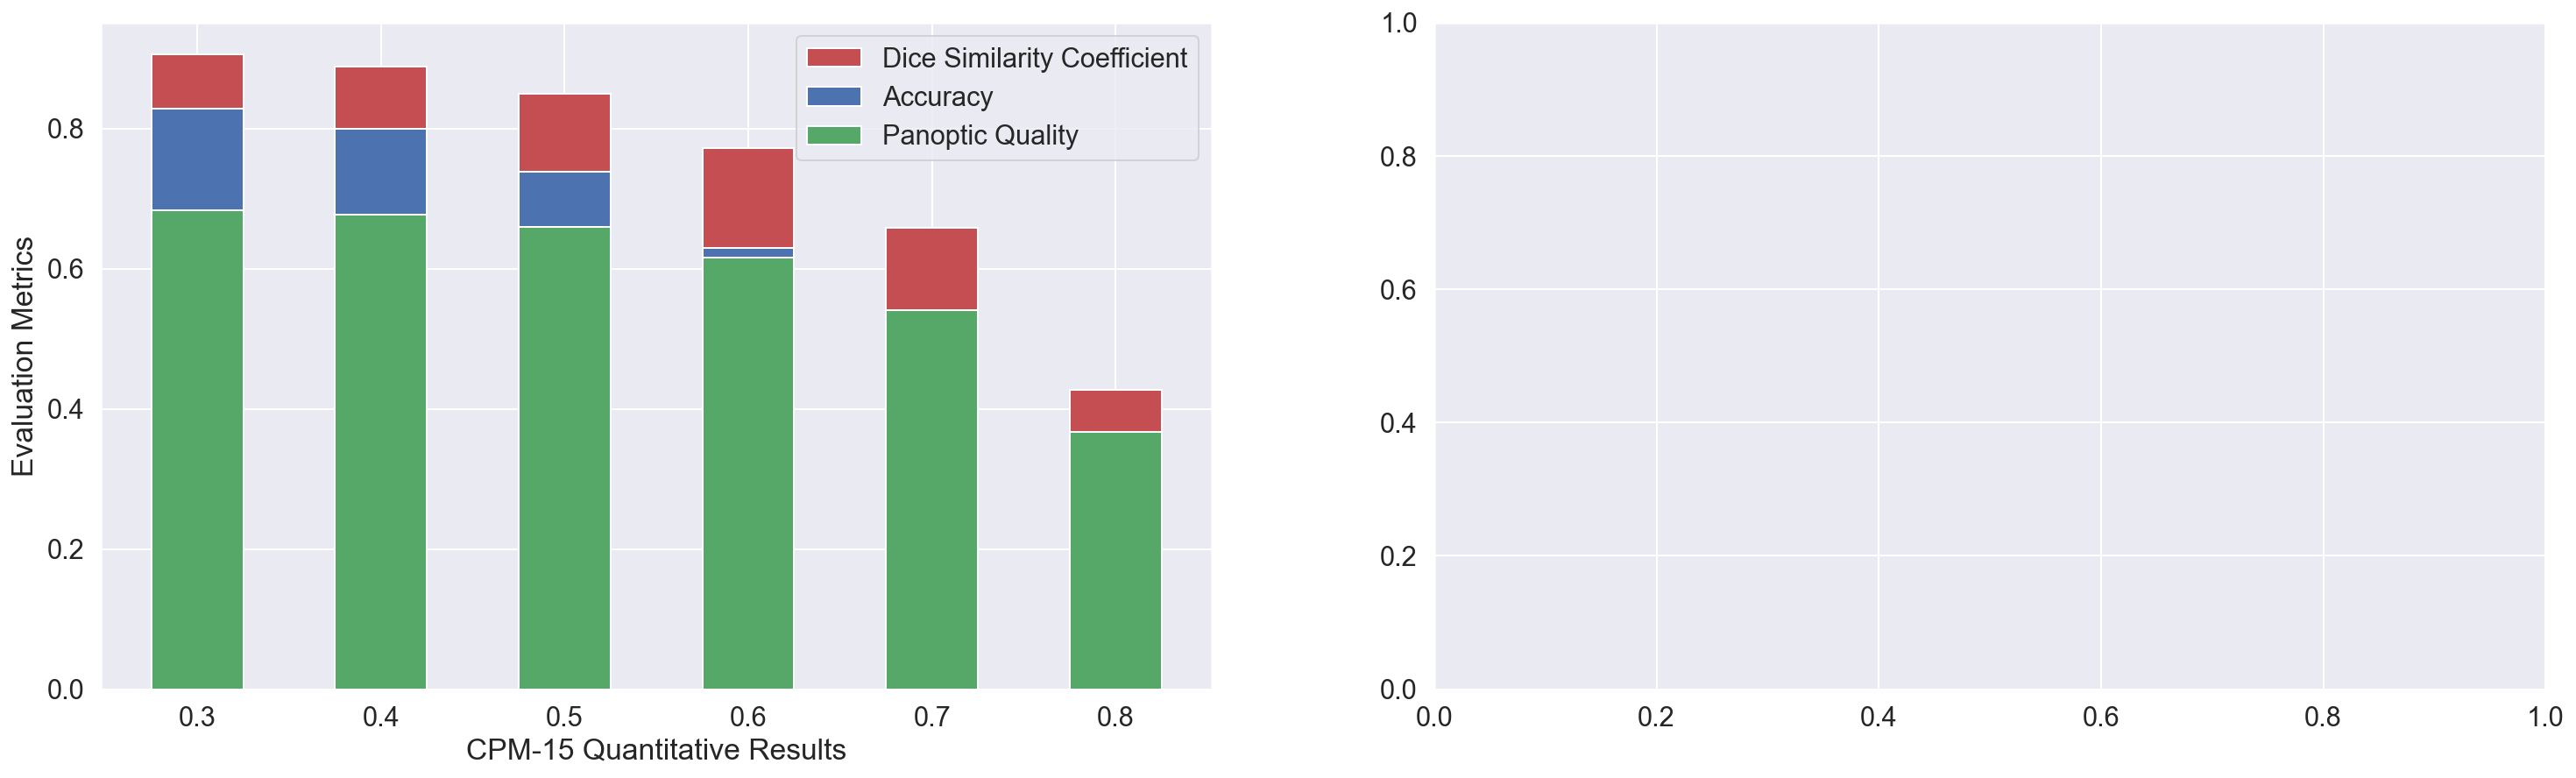

In [97]:
taus1 = [ 0.3,0.4, 0.5, 0.6, 0.7, 0.8]
stats1 = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus1)]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(25,7))
colors = "bgr"
i= -1
j=0
for m in (  'f1','accuracy','panoptic_quality'):
    ax1.bar(taus1, [s._asdict()[m] for s in stats1], width=0.05, label=m, color=colors[i])
    i=i+1

ax1.set_xlabel(r'CPM-15 Quantitative Results')
ax1.set_ylabel('Evaluation Metrics')
# t="CPM-17 Quantitative Results"
# ax1.title(t)
# ax1.grid()
ax1.legend()
L=ax1.legend()
L.get_texts()[0].set_text('Dice Similarity Coefficient')
L.get_texts()[1].set_text('Accuracy')
L.get_texts()[2].set_text('Panoptic Quality')